In [1]:
import os
import sys
sys.path.append('../..')

import pyedflib
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import signal
from imp import reload
import pandas as pd
import pywt
import readFiles
import databasePreparation
import preProcessing
import readEogertData
import math
from scipy import ndimage, misc
import json
import string
import neurokit2 as nk
import mne
import eeg_label
import evaluationUtils

from visualization import plotEogElectrodesSignal, plotVertHorEOG, plotSaccadeSpanInSignal, plotTransformAndPeaks, plotSaccadeGTSpanInSignal, plotSaccadeIntervals
from classificationUtils import peaksToBinary, peaksBinarySaccadeAnalysisVersion2, peaksBinaryToString, countEyeMovements, findPeaks
from evaluationUtils import countCorrectDetected, calculatePrecision, calculateRecall

## Reading the signal

This first part reads the edf file from a specific path and finds the channels that will be used for the analysis of the EOG.

These index of these channels are specified in the channelsOfInterest list.

In [2]:
# Reading the signals from the EDF file
sectionName = 'wassim0'
fileName = 'C:/Users/Ricardo/source/enac-eog-analysis/src/labelAnnotation/EOGLabel-main/{}.edf'.format(sectionName)
channelsOfInterest = [64, 65, 66, 67, 68, 69]

# 64 - EXG1 = EOG D
# 65 - EXG2 = EOG G
# 66 - EXG3 = EOG D INTERNAL
# 67 - EXG4 = EOG G INTERNAL
# 68 - EXG5 = EOG H
# 69 - EXG6 = EOG B


# Reading the signals from the EDF file
try:
    f = pyedflib.EdfReader(fileName)
except FileNotFoundError as e:
    print(e)
    print('\n The {} file was not found.'.format(fileName))

# numSignals = f.signals_in_file

# These are the numbers of the channels that interest us
#channelsOfInterest = [256, 257, 258, 259]
numEyeChannels = len(channelsOfInterest)

# signal_labels = f.getSignalLabels()
# print(signal_labels)

# Creation of a zero array the correct dimensions.
eyesData = np.zeros((numEyeChannels, f.getNSamples()[0]))

for i, channel in enumerate(channelsOfInterest):
    eyesData[i, :] = f.readSignal(channel)

f.close()

freqSample = 2048

## Pre processing of the EOG and classification of the eye movements

The signal is pre processed using a median filter with a sliding window of 200 samples.

Then the CWT Mexican Wavelet is applied and its coeficients are used for peak detections.

The peaks of the coeficients of the CWT are used to detect the movements in the EOG signal.

In the vertical EOG, a negative peak followed by a positive peak is considered an upwards saccade, for example.


Vertical and Horizontal Denoised signal Plot


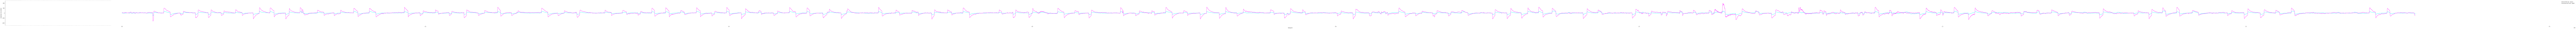

Vertical Saccades Plot


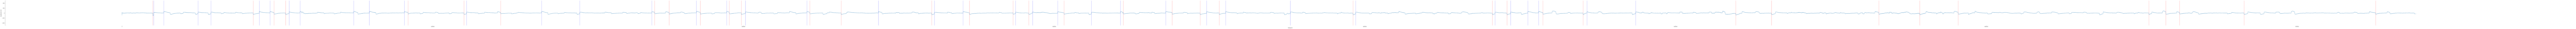

Vertical Saccades GroundTruth Plot


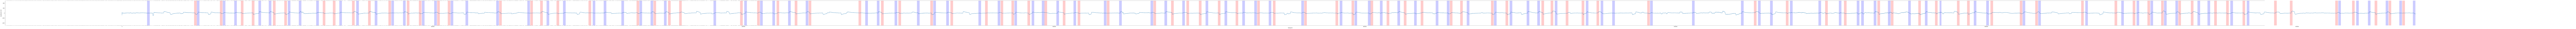

CWT Peaks Plot


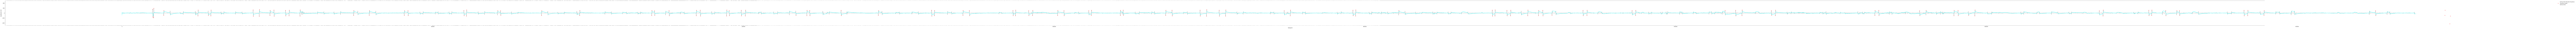

Horizontal Saccades Plot


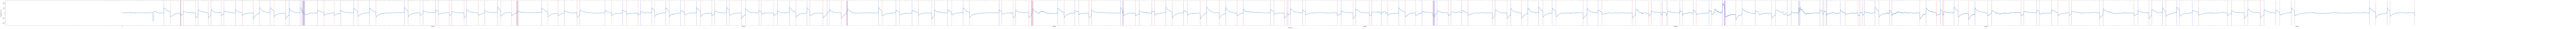

Horizontal Saccades GroundTruth Plot


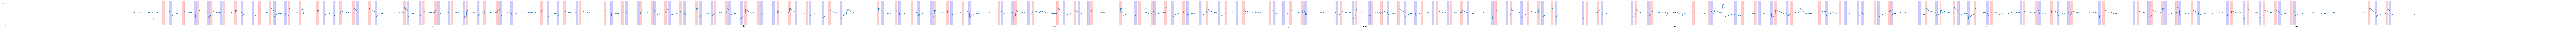

CWT Peaks Plot


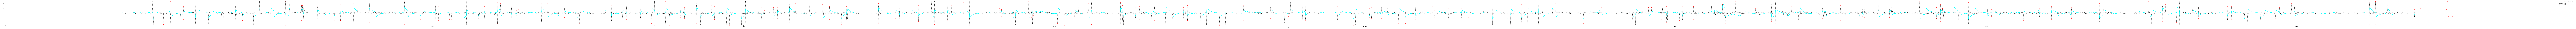

In [4]:
resultsPath = 'results/'


verticalEOG, horizontalEOG = preProcessing.electrodesToVertHori(eyesData, 0, 1, 2, 3)

verticalEogDenoised = ndimage.median_filter(verticalEOG, size = 200)
horizontalEogDenoised = ndimage.median_filter(horizontalEOG, size = 200)

verticalEOG = verticalEogDenoised
horizontalEOG = horizontalEogDenoised

verticalEOG = databasePreparation.resampleSignal(verticalEOG, 1000, 2048)
horizontalEOG = databasePreparation.resampleSignal(horizontalEOG, 1000, 2048)

# verticalEOG = preProcessing.cutArtifacts(verticalEOG, 700)
# horizontalEOG = preProcessing.cutArtifacts(horizontalEOG, 700)

verticalEOG3 = np.reshape(verticalEOG, (len(verticalEOG),1))
horizontalEOG3 = np.reshape(horizontalEOG, (len(horizontalEOG),1))

coefVertMexHat, freqsVertMexHat = pywt.cwt(verticalEOG, 30, 'mexh')
coefHoriMexHat, freqsHoriMexHat = pywt.cwt(horizontalEOG, 30, 'mexh')

coefVertMexHat1 = np.reshape(coefVertMexHat, (len(coefVertMexHat[0]),1))
coefHoriMexHat1 = np.reshape(coefHoriMexHat, (len(coefHoriMexHat[0]),1))

#coefVertMexHat2 = preProcessing.zeroPadArtifacts(coefVertMexHat1, 70)

# Peakfinding

# Flatten the vectors so they can be used in the signal.find_peaks function
vertCwt = coefVertMexHat1.flatten()
horiCwt = coefHoriMexHat1.flatten()

# Thresholds of the saccade peaks
peaksHeight = np.array([90, 600])
minSaccadeDistance = 100

# Returns peaks' indexes and their properties in a dict
# The peaks are detected in the module version of signal in order to find the negative peaks as well
peaksV = findPeaks(vertCwt, peaksHeight[0], peaksHeight[1], minSaccadeDistance)
peaksH = findPeaks(horiCwt, peaksHeight[0], peaksHeight[1], minSaccadeDistance)

vertPeaksBinary = peaksToBinary(peaksV, vertCwt)
horiPeaksBinary = peaksToBinary(peaksH, horiCwt)

upSaccadeStartEnd, downSaccadeStartEnd = peaksBinarySaccadeAnalysisVersion2(vertPeaksBinary, jumpIntervalThreshold=500)
leftSaccadeStartEnd, rightSaccadeStartEnd = peaksBinarySaccadeAnalysisVersion2(horiPeaksBinary, jumpIntervalThreshold=500)

# Detecting saccades candidates and blink candidates
vertPeaksString = peaksBinaryToString(vertPeaksBinary[2])
horiPeaksString = peaksBinaryToString(horiPeaksBinary[2])

# Reading the groundtruth for this file

saccadeGroundTruth = databasePreparation.loadNumpyArray('C:/Users/Ricardo/source/enac-eog-analysis/src/labelAnnotation/EOGLabel-main/{}_saccadeTimeStamp.npy'.format(sectionName))
saccadeGroundTruth = saccadeGroundTruth.tolist()

up_correctSaccades, up_incorrectSaccades = evaluationUtils.saccadeEvaluation(upSaccadeStartEnd, 'up', saccadeGroundTruth)
down_correctSaccades, down_incorrectSaccades = evaluationUtils.saccadeEvaluation(downSaccadeStartEnd, 'down', saccadeGroundTruth)
left_correctSaccades, left_incorrectSaccades = evaluationUtils.saccadeEvaluation(leftSaccadeStartEnd, 'left', saccadeGroundTruth)
right_correctSaccades, right_incorrectSaccades = evaluationUtils.saccadeEvaluation(rightSaccadeStartEnd, 'right', saccadeGroundTruth)

#All the plots

print('Vertical and Horizontal Denoised signal Plot')
plotVertHorEOG(verticalEogDenoised, horizontalEogDenoised,  mode='both')
plt.show()

print('Vertical Saccades Plot')
plotSaccadeSpanInSignal(verticalEOG, upSaccadeStartEnd, downSaccadeStartEnd)
plt.show()

print('Vertical Saccades GroundTruth Plot')
plotSaccadeGTSpanInSignal(verticalEOG, saccadeGroundTruth, 'vertical')
plt.show()

print('CWT Peaks Plot')
plotTransformAndPeaks(coefVertMexHat1, peaksV, verticalEOG, 'Vertical')
plt.show()

print('Horizontal Saccades Plot')
plotSaccadeSpanInSignal(horizontalEOG, leftSaccadeStartEnd, rightSaccadeStartEnd)
plt.show()

print('Horizontal Saccades GroundTruth Plot')
plotSaccadeGTSpanInSignal(horizontalEOG, saccadeGroundTruth, 'horizontal')
plt.show()

print('CWT Peaks Plot')
plotTransformAndPeaks(coefHoriMexHat1, peaksH, horizontalEOG, 'Horizontal')
plt.show() 



 Number of saccades in the groundtruth:  258




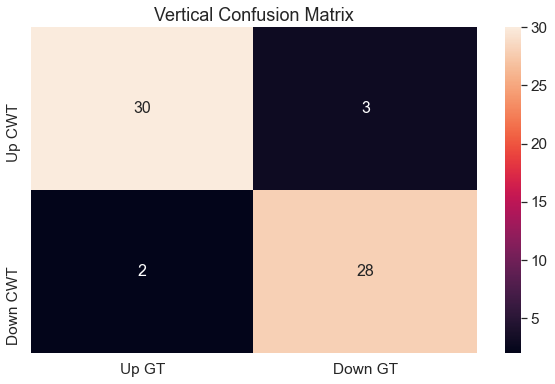

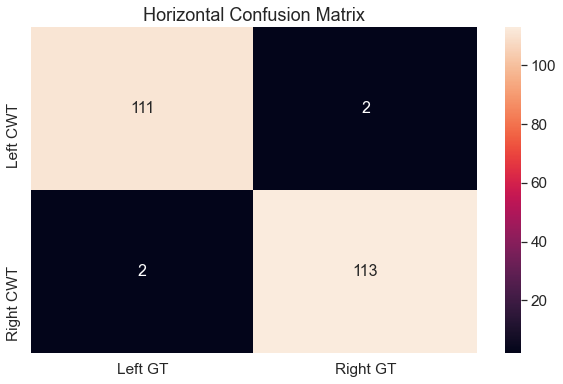


Precision:  0.78

Recall:  0.97

F1 Score: 0.87

False Positives (up, down, left, right)s:  15 8 26 30


In [5]:
print('\n Number of saccades in the groundtruth: ', len(saccadeGroundTruth))
print('\n')

allDirSaccadeStartEnd = [upSaccadeStartEnd, downSaccadeStartEnd, rightSaccadeStartEnd, leftSaccadeStartEnd]
evaluationUtils.confusionMatrix(allDirSaccadeStartEnd, saccadeGroundTruth, resultsPath, sectionName)

[upSaccadeTP, upSaccadeFN, upSaccadeFP, downSaccadeTP, downSaccadeFN, downSaccadeFP, leftSaccadeTP,
     leftSaccadeFN, leftSaccadeFP, rightSaccadeTP, rightSaccadeFN, rightSaccadeFP] = evaluationUtils.saccadeConfusion(
        allDirSaccadeStartEnd, saccadeGroundTruth)